# How to rediscover the Higgs boson yourself! - SVM
This notebook uses ATLAS Open Data http://opendata.atlas.cern to show you the steps to rediscover the Higgs boson yourself!

The idea is that you add extra cuts to increase the ratio of signal ($H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$) to background ($Z, t\bar{t}, ZZ \rightarrow \ell\ell\ell\ell$)

First, try to reduce the amount of $Z$ and $t\bar{t}$ background, since these are quite different to the signal.

Then, try to reduce the amount of $ZZ \rightarrow \ell\ell\ell\ell$, whilst keeping $H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$ signal

The datasets used in this notebook have already been filtered to include at least 4 leptons per event, so that processing is quicker.

This notebook was inspired by https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html

<!-- <CENTER><img src="../HZZ_feynman.pdf" style="width:40%"></CENTER> -->

## First time setup
This first cell only needs to be run the first time you open this notebook on your computer. 

If you close jupyter and re-open on the same computer, you won't need to run this first cell again.

If you re-open on binder, you will need to run this cell again.

If you run into a problem of "uproot not being available", Kernel -> Restart & Run All

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade --user pip
!{sys.executable} -m pip install -U numpy pandas uproot matplotlib keras scikit-learn --user

## To setup everytime
Cell -> Run All Below

to be done every time you re-open this notebook

In [1]:
import uproot
import pandas as pd
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import glob
import random

import infofile

In [2]:
lumi = 1000
                                                                                                                                  
tuple_path = "../Input/"

stack_order = ['data',r'$Z,t\bar{t}$','ZZ',r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$']

In [3]:
samples = {

    'data': {
        'list' : ['DataEgamma','DataMuons']
    },

    r'$Z,t\bar{t}$' : {
        'list' : ['Zee','Zmumu','ttbar_lep'],
        'color' : "#8700da"
    },

    'ZZ' : {
        'list' : ['ZZ'],
        'color' : "#f90000"
    },

    r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$' : {
        'list' : ['ggH125_ZZ4lep','VBFH125_ZZ4lep'],
        'color' : "#4faeff"
    }

}

In [4]:
def get_data_from_files():

    data = {}

    for s in samples:
        print(s+':')
        frames = []
        for val in samples[s]['list']:
            prefix = "MC/skim.mc_"
            if s == 'data':
                prefix = "Data/skim."
            else: prefix += str(infofile.infos[val]["DSID"])+"."
            fileString = tuple_path+prefix+val+".root"
            print(fileString)
            f = glob.glob(fileString,recursive=False)[0]
            if f != "":
                temp = read_file(f,val)
                frames.append(temp)
            else:
                print("Error: "+val+" not found!")
        data[s] = pd.concat(frames)

    return data

In [5]:
def mllll_window(mllll):
    return 120 < mllll < 130

In [6]:
def calc_weight(mcWeight,scaleFactor_PILEUP,scaleFactor_ELE,
                scaleFactor_MUON, scaleFactor_TRIGGER):
    return mcWeight*scaleFactor_PILEUP*scaleFactor_ELE*scaleFactor_MUON*scaleFactor_TRIGGER

In [7]:
def get_xsec_weight(totalWeight,sample):
    info = infofile.infos[sample]
    weight = (lumi*info["xsec"])/(info["sumw"]*info["red_eff"])
    weight *= totalWeight
    return weight

In [8]:
def correlations(data, title, **kwds):
    """Calculate pairwise correlation between features.
    
    Extra arguments are passed on to DataFrame.corr()
    """
    # simply call df.corr() to get a table of
    # correlation values if you do not need
    # the fancy plotting
    corrmat = data.corr(**kwds)

    fig, ax1 = plt.subplots(ncols=1, figsize=(6,5))
    
    opts = {'cmap': plt.get_cmap("RdBu"),
            'vmin': -1, 'vmax': +1}
    heatmap1 = ax1.pcolor(corrmat, **opts)
    plt.colorbar(heatmap1, ax=ax1)

    ax1.set_title(title+" Correlations")

    labels = corrmat.columns.values
    for ax in (ax1,):
        # shift location of ticks to center of the bins
        ax.set_xticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_yticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_xticklabels(labels, minor=False, ha='right', rotation=70)
        ax.set_yticklabels(labels, minor=False)
        
    plt.tight_layout()

In [9]:
def plot_data(data):

    bins = [80 + x*5 for x in range(35) ]
    data_x = [82.5 + x*5 for x in range(34) ]

    data_mllll = []
    data_mllll_errors = []

    mc_mllll = []
    mc_weights = []
    mc_colors = []
    mc_labels = []
    mc_in_mllll_window = [] # list for numbers of MC events with 120 < mllll < 130 GeV

    for s in stack_order:
        if s == "data":
            data_mllll,_ = np.histogram(data[s].mllll.values, bins=bins)
            data_mllll_errors = np.sqrt(data_mllll)
        else:
            mc_labels.append(s)
            mc_mllll.append(data[s].mllll.values)
            mc_colors.append(samples[s]['color'])
            mc_weights.append(data[s].totalWeight.values)
            mc_in_mllll_window.append([data[s].totalWeight.values[mllll_iter] for mllll_iter in range(len(data[s].mllll.values)) if 120 < data[s].mllll.values[mllll_iter] < 130])
    
    HZZ_in_mllll_window = sum(mc_in_mllll_window[2]) # number signal MC events with 120 < mllll < 130 GeV
    background_in_mllll_window = sum(mc_in_mllll_window[0]+mc_in_mllll_window[1]) # number background MC events with 120 < mllll < 130 GeV
    SoversqrtB = HZZ_in_mllll_window/math.sqrt(background_in_mllll_window) # calculate significance
    print('Signal/sqrt(Background) for 120<mllll<130 '+str(SoversqrtB))
    
    top = np.amax(data_mllll)+math.sqrt(np.amax(data_mllll))

    plt.figure()
    plt.hist(mc_mllll,bins=bins,weights=mc_weights,stacked=True,color=mc_colors, label=mc_labels)
    plt.errorbar( x=data_x, y=data_mllll, yerr=data_mllll_errors, fmt='ko', label='Data')

    #X = np.arange(115,135,5) # gives list [115,120,125,130]
    #data_in_window = data_mllll[7:11] # gives list of data y value for [115,120,125,130]
    #x = np.sum(X*data_in_window)/np.sum(data_in_window) # Gaussian mean
    #width = np.sqrt(np.abs(np.sum((X-x)**2*data_in_window)/np.sum(data_in_window))) # Gaussian width
    #fit = lambda t : np.amax(data_in_window)*np.exp(-(t-x)**2/(2*width**2)) # Gaussian fit
    #plt.plot(X, fit(X), '-') # plot Gaussian
    
    plt.xlabel(r'$M_{\ell\ell\ell\ell}$ [GeV]',fontname='sans-serif',horizontalalignment='right',x=1.0,fontsize=11)

    plt.ylabel(r'Events',fontname='sans-serif',horizontalalignment='right',y=1.0,fontsize=11)
    #plt.yscale('log')                                                                                                                                                                        
    plt.ylim(bottom=0,top=top)

    ax = plt.gca()
    plt.text(0.05,0.97,r'$\mathbf{{ATLAS}}$ Open Data',ha="left",va="top",family='sans-serif',transform=ax.transAxes,fontsize=13)
    plt.text(0.05,0.92,'for education only',ha="left",va="top",family='sans-serif',transform=ax.transAxes,style='italic',fontsize=8)
    plt.text(0.05,0.9,r'$\sqrt{s}=8\,\mathrm{TeV},\;\int L\,dt=1\,\mathrm{fb}^{-1}$',ha="left",va="top",family='sans-serif',transform=ax.transAxes)

    plt.legend()

    plt.savefig("plot.pdf")
    
    # boxplot of signal and background mllll
    #plt.figure()
    #for s in stack_order:
    #    if s != 'data': data[s]['Process'] = s
    #data_all = pd.concat([data[r'$Z,t\bar{t}$'],data['ZZ'],data[r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$']])
    #data_all.boxplot(by='Process',column=["mllll"])
    
    # plot correlation matrices for signal and background
    #correlations(pd.concat([data[r'$Z,t\bar{t}$'],data['ZZ']]),"background")
    #correlations(data[r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$'], "signal")

    return

In [10]:
def calc_mllll(lep_pts,lep_etas,lep_phis):
    theta_0 = 2*math.atan(math.exp(-lep_etas[0]))
    theta_1 = 2*math.atan(math.exp(-lep_etas[1]))
    theta_2 = 2*math.atan(math.exp(-lep_etas[2]))
    theta_3 = 2*math.atan(math.exp(-lep_etas[3]))
    p_0 = lep_pts[0]/math.sin(theta_0)
    p_1 = lep_pts[1]/math.sin(theta_1)
    p_2 = lep_pts[2]/math.sin(theta_2)
    p_3 = lep_pts[3]/math.sin(theta_3)
    pz_0 = p_0*math.cos(theta_0)
    pz_1 = p_1*math.cos(theta_1)
    pz_2 = p_2*math.cos(theta_2)
    pz_3 = p_3*math.cos(theta_3)
    px_0 = p_0*math.sin(theta_0)*math.cos(lep_phis[0])
    px_1 = p_1*math.sin(theta_1)*math.cos(lep_phis[1])
    px_2 = p_2*math.sin(theta_2)*math.cos(lep_phis[2])
    px_3 = p_3*math.sin(theta_3)*math.cos(lep_phis[3])
    py_0 = p_0*math.sin(theta_0)*math.sin(lep_phis[0])
    py_1 = p_1*math.sin(theta_1)*math.sin(lep_phis[1])
    py_2 = p_2*math.sin(theta_2)*math.sin(lep_phis[2])
    py_3 = p_3*math.sin(theta_3)*math.sin(lep_phis[3])
    sumpz = pz_0 + pz_1 + pz_2 + pz_3
    sumpx = px_0 + px_1 + px_2 + px_3
    sumpy = py_0 + py_1 + py_2 + py_3
    sumE = p_0 + p_1 + p_2 + p_3
    mllll = sumE**2 - sumpz**2 - sumpx**2 - sumpy**2
    return math.sqrt(mllll)/1000.

In [11]:
def calc_mll(lep_pts,lep_etas,lep_phis):
    # this is only pseudo-code to tell you what to do!
    # you need to decide how to find i & j yourself
    mll = 2*lep_pts[i]*lep_pts[j!=i]
    cosh = math.cosh(lep_etas[i]-lep_etas[j!=i])
    cos = math.cos(lep_phis[i]-lep_phis[j!=i])
    mll *= ( cosh - cos )
    return math.sqrt(mll)/1000.

## Uncommenting a new cut
If you add a cut: Cell -> Run All Below

In [89]:
def read_file(path,sample):
    start = time.time()
    print("\tProcessing: "+sample)
    mc = uproot.open(path)["mini"]
#     data = mc.pandas.df(["lep_n","lep_pt","lep_eta","lep_phi","lep_charge","lep_type","lep_etcone20","lep_trackd0pvunbiased","lep_tracksigd0pvunbiased",
#                          "mcWeight","scaleFactor_PILEUP","scaleFactor_ELE","scaleFactor_MUON", # add more variables here if you make cuts on them
#                          "scaleFactor_TRIGGER"], flatten=False)
    data = pd.DataFrame(mc.arrays(["lep_n","lep_pt","lep_eta","lep_phi","lep_charge","lep_type","lep_etcone20","lep_trackd0pvunbiased","lep_tracksigd0pvunbiased",
                         "mcWeight","scaleFactor_PILEUP","scaleFactor_ELE","scaleFactor_MUON", # add more variables here if you make cuts on them
                         "scaleFactor_TRIGGER"], library ='np') #,columns = ["lep_n","lep_pt","lep_eta","lep_phi","lep_charge","lep_type","lep_etcone20","lep_trackd0pvunbiased","lep_tracksigd0pvunbiased","mcWeight","scaleFactor_PILEUP","scaleFactor_ELE","scaleFactor_MUON","scaleFactor_TRIGGER"]
                       )
    nIn = len(data.index)

    if 'Data' not in sample:
        data['totalWeight'] = np.vectorize(calc_weight)(data.mcWeight,data.scaleFactor_PILEUP,data.scaleFactor_ELE,data.scaleFactor_MUON,data.scaleFactor_TRIGGER)
        data['totalWeight'] = np.vectorize(get_xsec_weight)(data.totalWeight,sample)

    data.drop(["mcWeight","scaleFactor_PILEUP","scaleFactor_ELE","scaleFactor_MUON","scaleFactor_TRIGGER"], axis=1, inplace=True)
    
    # cut on minimum lepton pt
    
    # cut on lepton etcone20
    
    # cut on lepton d0
    
    # example of adding column that takes the return of the function cut_lep_pt_min
    #data['lep_pt_min'] = data.apply(cut_lep_pt_min,axis=1)
    
    # example of cut on minimum number of leptons passing baseline requirements
    #fail = data[ np.vectorize(cut_n_lep_min)(data.lep_pt_min) ].index
    #data.drop(fail, inplace=True)
    
    # cut on number of leptons
    fail = data[ np.vectorize(cut_n_lep)(data.lep_n) ].index
    data.drop(fail, inplace=True)

    # cut on lepton charge
#     fail = data[ np.vectorize(cut_lep_charge)(data.lep_charge) ].index
#     data.drop(fail, inplace=True)
    
    #print(data)
    
    # cut on lepton type
    fail = data[ np.vectorize(cut_lep_type)(data.lep_type) ].index
    data.drop(fail, inplace=True)
    
    # cut on lepton pt
    fail = data[ np.vectorize(cut_lep_pt2)(data.lep_pt) ].index
    data.drop(fail, inplace=True)
    
    # cut on deltaR
    #fail = data[ np.vectorize(cut_deltaR)(data.lep_eta,data.lep_phi...
    #data.drop(fail, inplace=True)
    
    # cut on minimum opposite-charge-same-type lepton pair invariant mass
    #fail = data[ np.vectorize(cut_OCST)(data....

    # calculation of Z boson candidate 1 invariant mass
    #data['mZ1'] = np.vectorize(calc_mZ1)(data.lep_pt,data.lep_eta,data.lep_phi)
    
    # cut on mZ1
    #fail = data[ np.vectorize(cut_mZ1)(data.mZ1) ].index
    #data.drop(fail, inplace=True)
    
    # calculation of Z boson candidate 2 invariant mass
    #data['mZ2'] = np.vectorize(calc_mZ2)(data....
    
    # cut on mZ2
    #fail = data[ np.vectorize(cut_mZ2)(data.mZ2) ].index
    #data.drop(fail, inplace=True)
    
    # calculation of 4-lepton invariant mass
    data['mllll'] = np.vectorize(calc_mllll)(data.lep_pt,data.lep_eta,data.lep_phi)

    mllll_window_list = data[ np.vectorize(mllll_window)(data.mllll) ] # return events with 120 < mllll < 130 GeV
    
    # example of expanding lep_pt list column into individual columns whilst requiring exactly 4 leptons
    # need to change cut_lep_n to require exactly 4 leptons
    #data[['lep1_pt','lep2_pt','lep3_pt','lep4_pt']] = pd.DataFrame(data.lep_pt.values.tolist(), index= data.index)

    # example of expanding lep_pt list column into individual columns without requiring exactly 4 leptons
    # need to do this for columns that you wish to use for fit_BDT
    #if max(data.lep_n) < 5: 
    #    df_split = pd.DataFrame(data['lep_pt'].values.tolist(), columns=['lep1_pt','lep2_pt','lep3_pt','lep4_pt'], index=data.index)
    #    df_split['lep5_pt'] = 0
    #    df_split['lep6_pt'] = 0
    #elif max(data.lep_n) < 6: 
    #    df_split = pd.DataFrame(data['lep_pt'].values.tolist(), columns=['lep1_pt','lep2_pt','lep3_pt','lep4_pt','lep5_pt'], index=data.index)
    #    df_split['lep6_pt'] = 0
    #else: df_split = pd.DataFrame(data['lep_pt'].values.tolist(), columns=['lep1_pt','lep2_pt','lep3_pt','lep4_pt','lep5_pt','lep6_pt'], index=data.index)
    #df_split.fillna(0, inplace=True)
    #data = pd.concat([data, df_split], axis=1)
    
    #print(data)

    nOut = len(data.index)

    elapsed = time.time() - start
    print("\t\tTime taken: "+str(elapsed)+", nIn: "+str(nIn)+", nOut: "+str(nOut))
    
    return data

## Changing an already uncommented cut

If you change a cut: Cell -> Run All Below

If you uncomment a cut here, you also need to uncomment the corresponding cut in the cell above.

In [76]:
# cut on number of leptons
def cut_n_lep(lep_n):
    # return when number of leptons is less than 4
    return lep_n < 4

# cut on lepton charge
def cut_lep_charge(lep_charge):
    # return when sum of lepton charges is not equal to 0
    # exclamation mark (!) means "not"
    # so != means "not equal to"
    # first lepton is [0], 2nd lepton is [1] etc
    return lep_charge[0] + lep_charge[1] + lep_charge[2] + lep_charge[3] != 0

# cut on lepton type
def cut_lep_type(lep_type):
# for an electron lep_type is 11
# for a muon lep_type is 13
    sum_lep_type = lep_type[0] + lep_type[1] + lep_type[2] + lep_type[3]
    return (lep_type[0]+lep_type[1]+lep_type[2]+lep_type[3] != 44) and (lep_type[0]+lep_type[1]+lep_type[2]+lep_type[3] != 48) and (lep_type[0]+lep_type[1]+lep_type[2]+lep_type[3] != 52)

# cut on lepton pt

def cut_lep_pt2(lep_pt):
    return np.sum(lep_pt>7000, axis=0)!=4

#def cut_lep_pt(lep_pt):
# want to throw away events where the 2nd highest pt lepton used has lep_pt[1] < 15000
# want to throw away events where the 3rd highest pt lepton used has lep_pt[2] < 10000

# cut on minimum opposite-charge-same-type lepton pair invariant mass
#def cut_mOCST():
# want to throw away events if the invariant mass of any opposite-charge-same-type lepton pair is < 5

# cut on invariant mass of Z boson candidate 1
#def cut_mZ1(mZ1):
# want invariant mass of same-type-opposite-charge lepton pair that's closest to Z mass (91 GeV) to be in range 50 < m < 106 GeV

# cut on invariant mass of Z boson candidate 2
#def cut_mZ2(mZ2):
# want invariant mass of remaining lepton pair that's closest to Z mass (91 GeV) to be in range 17.5 < m < 115 GeV
# advanced: vary the lower range monotically from 17.5 at mllll=120 to 50 at mllll=190, and constant above mllll=190

# cut on deltaR
# want to throw away leptons that are separated from all other leptons by deltaR = math.sqrt(delta(lep_eta)**2 + delta(lep_phi)**2) < 0.2
# want to throw away leptons that are separated from other leptons of the same type by deltaR = math.sqrt(delta(lep_eta)**2 + delta(lep_phi)**2) < 0.1

# example of returning list where every element passes minimum lep_pt requirement
#def cut_lep_pt_min(data):
#    return [data.lep_pt[i] for i in range(len(data.lep_pt)) if data.lep_pt[i] > 6000]

# cut on minimum lepton pt
# want to throw away muons with lep_pt < 6000
# want to throw away electrons with lep_pt < 7000

# cut on maximum lepton etcone20
# want to throw away muons with lep_etcone20/lep_pt < 0.3
# want to throw away electrons with lep_etcone20/lep_pt < 0.2

# cut on maximum lepton d0
# want to throw away muons with lep_trackd0pvunbiased/lep_tracksigd0pvunbiased < 3.5
# want to throw away electrons with lep_trackd0pvunbiased/lep_tracksigd0pvunbiased < 6.5

# example of cutting on length of list passing minimum requirements
#def cut_n_lep_min(lep_pt_min):
#    return len(lep_pt_min) < 4

data:
../Input/Data/skim.DataEgamma.root
	Processing: DataEgamma
		Time taken: 0.0578310489654541, nIn: 89, nOut: 26
../Input/Data/skim.DataMuons.root
	Processing: DataMuons
		Time taken: 0.03890395164489746, nIn: 112, nOut: 34
$Z,t\bar{t}$:
../Input/MC/skim.mc_147770.Zee.root
	Processing: Zee
		Time taken: 0.0625309944152832, nIn: 720, nOut: 123
../Input/MC/skim.mc_147771.Zmumu.root
	Processing: Zmumu
		Time taken: 0.14286255836486816, nIn: 1057, nOut: 155
../Input/MC/skim.mc_117050.ttbar_lep.root
	Processing: ttbar_lep
		Time taken: 0.05921649932861328, nIn: 897, nOut: 201
ZZ:
../Input/MC/skim.mc_105986.ZZ.root
	Processing: ZZ
		Time taken: 0.13576769828796387, nIn: 1973, nOut: 1771
$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$:
../Input/MC/skim.mc_160155.ggH125_ZZ4lep.root
	Processing: ggH125_ZZ4lep
		Time taken: 0.913393497467041, nIn: 21783, nOut: 17654
../Input/MC/skim.mc_160205.VBFH125_ZZ4lep.root
	Processing: VBFH125_ZZ4lep
		Time taken: 0.9209070205688477, nIn: 20954, nOut: 

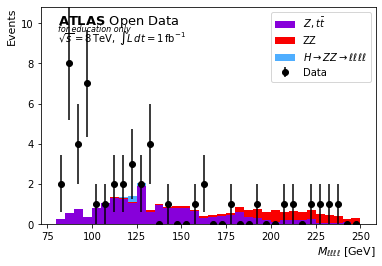

In [90]:
if __name__=="__main__":
    start = time.time()
    data = get_data_from_files()
    plot_data(data)
    elapsed = time.time() - start
    print("Time taken: "+str(elapsed))

## Motivating Support Vector Machines

Here we will consider discriminative classification: rather than modeling each class, we simply find a line or curve (in two dimensions) or manifold (in multiple dimensions) that divides the classes from each other.

As an example of this, consider the simple case of a classification task, in which the two classes of points are well separated:

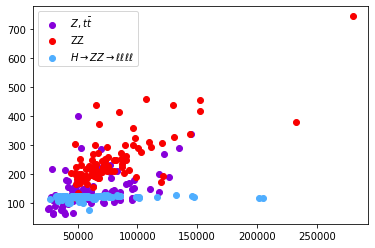

In [79]:
def scatter_plot(data):    
    
    # scatter plot of signal and background lep_n vs mllll
    #plt.figure()
    #for s in stack_order:
    #    if s != 'data': 
    #        idx = np.random.choice(np.arange(len(data[s].lep_n)), 100)
    #        plt.scatter(data[s].lep_n[idx],data[s].mllll[idx],color=samples[s]['color'],label=s)
    #plt.xlabel(r'Leptons',fontname='sans-serif',horizontalalignment='right',y=1.0,fontsize=11)
    #plt.ylabel(r'$M_{\ell\ell\ell\ell}$ [GeV]',fontname='sans-serif',horizontalalignment='right',x=1.0,fontsize=11)
    #plt.legend()
    
    # scatter plot of signal and background lep_pt[0] vs mllll
    plt.figure()
    for s in stack_order:
        if s != 'data': 
#             idx = np.random.choice(np.arange(len(data[s].lep_pt.apply(lambda x: x[0]))), 100)
#             plt.scatter(data[s].lep_pt.apply(lambda x: x[0])[idx],data[s].mllll[idx],color=samples[s]['color'],label=s)
            samp = data[s].sample(n=100)
            plt.scatter(samp.lep_pt.apply(lambda x: x[0]),samp.mllll,color=samples[s]['color'],label=s)
    plt.legend()
    
scatter_plot(data)

A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification. For two dimensional data like that shown here, this is a task we could do by hand. But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!

We can draw them as follows:

(80.0, 250.0)

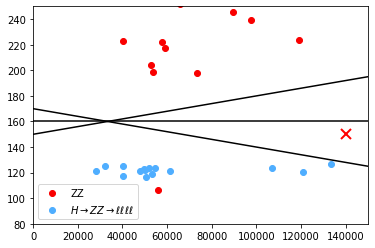

In [43]:
plt.figure()
xfit = np.linspace(0, 200000)
for s in stack_order:
    if s == 'ZZ' or s == r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$': 
        # plot 15 points to avoid overcrowding
        plt.scatter(data[s].lep_pt.apply(lambda x: x[0])[1:16],data[s].mllll[1:16],color=samples[s]['color'],label=s)
plt.legend()
plt.plot([140000], [150], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(0.00, 160), (0.0003, 150), (-0.0003, 170)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(0, 150000);
plt.ylim(80, 250)

These are three very different separators which, nevertheless, perfectly discriminate between these samples. Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label! Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.

## Support Vector Machines: Maximizing the Margin

Support vector machines offer one way to improve on this. The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a margin of some width, up to the nearest point. Here is an example of how this might look:

(80.0, 250.0)

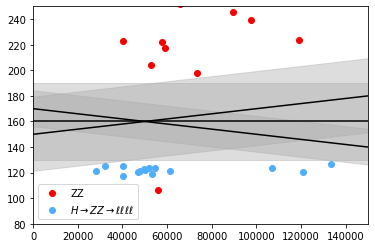

In [32]:
plt.figure()
xfit = np.linspace(0, 200000)
for s in stack_order:
    if s == 'ZZ' or s == r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$': 
        # plot 15 points to avoid overcrowding
        plt.scatter(data[s].lep_pt.apply(lambda x: x[0])[1:16],data[s].mllll[1:16],color=samples[s]['color'],label=s)
plt.legend()
plt.plot([190000], [150], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b, d in [(0.00, 160, 30), (0.0002, 150, 29), (-0.0002, 170, 14)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(0, 150000);
plt.ylim(80, 250)

In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model. Support vector machines are an example of such a maximum margin estimator.

### Fitting a support vector machine

Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier to train an SVM model on this data. For the time being, we will use a linear kernel and set the C parameter to a very large number (we'll discuss the meaning of these in more depth momentarily).

In [91]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E3)

# add isSignal variable
data[r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$']['isSignal'] = np.ones(len(data[r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$'])) 
data[r'$Z,t\bar{t}$']['isSignal'] = np.zeros(len(data[r'$Z,t\bar{t}$']))
data['ZZ']['isSignal'] = np.zeros(len(data['ZZ']))

df_all = pd.concat([data[r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$'][1:16],data['ZZ'][1:16]])

X = np.vstack((df_all.lep_pt.apply(lambda x: x[0]).values,df_all.mllll.values)).T

model.fit(X, df_all['isSignal'].values)

SVC(C=1000.0, kernel='linear')

To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us:

In [92]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


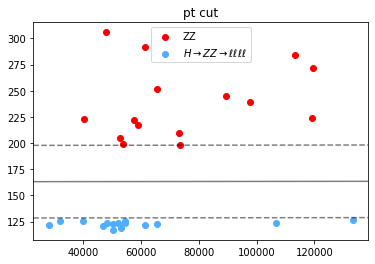

In [93]:
for s in stack_order:
    if s == 'ZZ' or s == r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$': 
        # plot 15 points to avoid overcrowding
        plt.scatter(data[s].lep_pt.apply(lambda x: x[0])[1:16],data[s].mllll[1:16],color=samples[s]['color'],label=s)
plt.legend()
plt.title('pt cut')
plot_svc_decision_function(model);
# plt.savefig('pt cut.png')

This is the dividing line that maximizes the margin between the two sets of points. Notice that a few of the training points just touch the margin: they are indicated by the black circles in this figure. These points are the pivotal elements of this fit, and are known as the support vectors, and give the algorithm its name. In Scikit-Learn, the identity of these points are stored in the *support_vectors_* attribute of the classifier:

In [94]:
model.support_vectors_

array([[73441.125     ,   198.203115  ],
       [53612.87109375,   198.88507438],
       [54358.07421875,   125.94534825]])

A key to this classifier's success is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit! Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

We can see this, for example, if we plot the model learned from the first 27 points and first 30 points of this dataset:

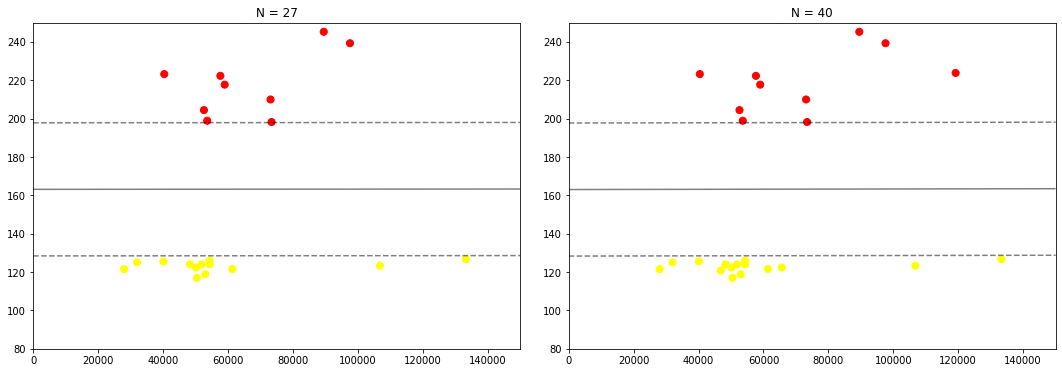

In [95]:
def plot_svm(N=15, ax=None):

    # add isSignal variable
    data[r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$']['isSignal'] = np.ones(len(data[r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$'])) 
    data[r'$Z,t\bar{t}$']['isSignal'] = np.zeros(len(data[r'$Z,t\bar{t}$']))
    data['ZZ']['isSignal'] = np.zeros(len(data['ZZ']))
    
    df_all = pd.concat([data[r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$'][1:16],data['ZZ'][1:16]]).sample(frac=1)

    X = np.vstack((df_all.lep_pt.apply(lambda x: x[0]).values,df_all.mllll.values)).T
    
    y = df_all['isSignal'].values

    X = X[:N]
    y = y[:N]

    model = SVC(kernel='linear', C=1E3)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(0, 150000)
    ax.set_ylim(80, 250)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [27, 40]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

In the left panel, we see the model and the support vectors for 27 training points. In the right panel, we have increased the number of training points, but the model has not changed: the three support vectors from the left panel are still the support vectors from the right panel. This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

In [96]:
from sklearn.metrics import classification_report, roc_auc_score
y_predicted = model.predict(X)>.5
y =df_all['isSignal'].values
print (classification_report(y, y_predicted,
                            target_names=["background", "signal"]))
print ("Area under ROC curve for test data: %.4f"%(roc_auc_score(y,
                                                    model.decision_function(X))))

              precision    recall  f1-score   support

  background       1.00      1.00      1.00        15
      signal       1.00      1.00      1.00        15

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

Area under ROC curve for test data: 1.0000
